In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr, zscore
import statistics 
import datetime

from scipy.integrate import simpson
from numpy import trapz


!pip install kaleido
import kaleido #required
kaleido.__version__ #0.2.1

import plotly
plotly.__version__ #5.5.0

#now this works:
import plotly.graph_objects as go

try:
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.seasonal import STL
except:
    !pip install statsmodels
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.seasonal import STL

try:
    from mpl_axes_aligner import align
except:
    !pip install mpl_axes_aligner
    from mpl_axes_aligner import align

try:
    import pydove as dv
except:
    !pip install pydove
    import pydove as dv

try:
    import plotly.graph_objects as go
except:
    !pip install plotly
    import plotly.graph_objects as go
# https://dev.to/kedarghule/how-to-build-a-interactive-bubble-map-in-python-using-plotly-537p
    
try:
    import lxml
except:
    !pip install lxml
    import lxml
# https://stackoverflow.com/questions/15799162/resampling-within-a-pandas-multiindex

from datetime import date
from dateutil.relativedelta import relativedelta

try:
    import dataframe_image as dfi
except:
    !pip install dataframe_image
    import dataframe_image as dfi
    
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import plotly.express as px

# https://www.kaggle.com/code/pavansanagapati/interactive-choropleth-point-maps-using-plotly

import plotly.tools as tls
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from plotly.subplots import make_subplots


try:
    import geopandas as gpd
except:
    !pip install geopandas
    import geopandas as gpd
pd.options.mode.chained_assignment = None  

import io
import PIL


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


## Functions

### This function aligns the origin and tick marks on two-axis graphs to improve their appearance
https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin

In [30]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

## Loading Data

all_tweets_merged_normalized_compact.csv contains the proportion of tweets for each day/location that are seasonal allergy-related. The other *.csv files are all geospatial data used to generate the maps.

In [31]:
all_tweets_merged = pd.read_csv('./project_data/all_tweets_merged_normalized_compact.csv')
all_tweets_merged['date'] = pd.to_datetime(all_tweets_merged['date'])
place_county_state = pd.read_csv('./project_data/usa_county_index.csv')
fips_counties = pd.read_csv('./project_data/fips_counties_centroid.csv')

In [32]:
place_state = place_county_state[['place_id','county_name','state','fips']]

In [33]:
county_state_in_set = pd.read_csv('./project_data/county_state.csv')

In [34]:
place_fips = pd.merge(county_state_in_set, place_state, on=['county_name','state'], how='left').sort_values(['county_name'], ascending=[True])
unique_fips = pd.DataFrame(place_fips.fips.unique(),columns=['fips'])

In [35]:
# Calculating an average year
# https://stackoverflow.com/questions/28304881/get-the-average-year-mean-of-days-over-multiple-years-in-pandas

yearly_avg_tweets_all = all_tweets_merged.groupby([all_tweets_merged.fips, all_tweets_merged.date.dt.month, all_tweets_merged.date.dt.day]).mean()
yearly_avg_tweets_all.index.names = ['fips','month','day']
yearly_avg_tweets_all.reset_index(inplace=True)
yearly_avg_tweets_all['date'] = yearly_avg_tweets_all.apply(lambda x:datetime.datetime(2020,x['month'].astype(int),x['day'].astype(int)),axis=1)
yearly_avg_tweets_all['date'] = yearly_avg_tweets_all['date'].dt.strftime('%m-%d')
yearly_avg_tweets_all = yearly_avg_tweets_all.drop(['month', 'day'], axis=1)

<ipython-input-35-d0fb6388aeb2>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [36]:
yearly_avg_tweets_all['14dra_1st'] = yearly_avg_tweets_all['14dra_percent'].diff()
yearly_avg_tweets_all['14dra_2nd'] = yearly_avg_tweets_all['14dra_1st'].diff()

### Generating z-scores for the two z-score maps

In [37]:
tot_roll_avgs = pd.DataFrame()

for i in  unique_fips['fips'].tolist():
    county = yearly_avg_tweets_all.loc[(yearly_avg_tweets_all['fips'] == i)]
    fips = i
    gmin = county['14dra_percent'].min()
    full_year = county
    full_year['14dra_percent_zeroed'] = full_year['14dra_percent']-gmin
    full_year_intensity = trapz(np.array(full_year['14dra_percent_zeroed']), dx=5)
    
    # calculate out intensity and z-score for each month
    # the z-score reflected here is internal to the county
    # on the map, the hue will represent how bad that month is compared to all the other months of the year for that county
    # bubble size will be the intensity
    # this will allow you to see what the worst months are per county for that county, as well as relative intensities between counties
    jan = full_year.loc[(full_year['date'] >= '01-01') & (full_year['date'] <= '01-31')]
    feb = full_year.loc[(full_year['date'] >= '02-01') & (full_year['date'] <= '02-29')]
    mar = full_year.loc[(full_year['date'] >= '03-01') & (full_year['date'] <= '03-30')]
    apr = full_year.loc[(full_year['date'] >= '04-01') & (full_year['date'] <= '04-31')]
    may = full_year.loc[(full_year['date'] >= '05-01') & (full_year['date'] <= '05-31')]
    jun = full_year.loc[(full_year['date'] >= '06-01') & (full_year['date'] <= '06-30')]
    jul = full_year.loc[(full_year['date'] >= '07-01') & (full_year['date'] <= '07-31')]
    aug = full_year.loc[(full_year['date'] >= '08-01') & (full_year['date'] <= '08-31')]
    sep = full_year.loc[(full_year['date'] >= '09-01') & (full_year['date'] <= '09-30')]
    oct = full_year.loc[(full_year['date'] >= '10-01') & (full_year['date'] <= '10-31')]
    nov = full_year.loc[(full_year['date'] >= '11-01') & (full_year['date'] <= '11-30')]
    dec = full_year.loc[(full_year['date'] >= '12-01') & (full_year['date'] <= '12-31')]

    jan_int = trapz(np.array(jan['14dra_percent_zeroed']), dx=5)
    feb_int = trapz(np.array(feb['14dra_percent_zeroed']), dx=5)
    mar_int = trapz(np.array(mar['14dra_percent_zeroed']), dx=5)
    apr_int = trapz(np.array(apr['14dra_percent_zeroed']), dx=5)
    may_int = trapz(np.array(may['14dra_percent_zeroed']), dx=5)
    jun_int = trapz(np.array(jun['14dra_percent_zeroed']), dx=5)
    jul_int = trapz(np.array(jul['14dra_percent_zeroed']), dx=5)
    aug_int = trapz(np.array(aug['14dra_percent_zeroed']), dx=5)
    sep_int = trapz(np.array(sep['14dra_percent_zeroed']), dx=5)
    oct_int = trapz(np.array(oct['14dra_percent_zeroed']), dx=5)
    nov_int = trapz(np.array(nov['14dra_percent_zeroed']), dx=5)
    dec_int = trapz(np.array(dec['14dra_percent_zeroed']), dx=5)

    data = np.array([jan_int,feb_int,mar_int,apr_int,may_int,jun_int,jul_int,aug_int,sep_int,oct_int,nov_int,dec_int])
    monthly_zs = zscore(data, axis=0)
    jan_z = monthly_zs[0]
    feb_z = monthly_zs[1]
    mar_z = monthly_zs[2]
    apr_z = monthly_zs[3]
    may_z = monthly_zs[4]
    jun_z = monthly_zs[5]
    jul_z = monthly_zs[6]
    aug_z = monthly_zs[7]
    sep_z = monthly_zs[8]
    oct_z = monthly_zs[9]
    nov_z = monthly_zs[10]
    dec_z = monthly_zs[11]
 
    new_row = pd.DataFrame([[fips,full_year_intensity,
                             jan_int,feb_int,mar_int,apr_int,may_int,jun_int,jul_int,aug_int,sep_int,oct_int,nov_int,dec_int,
                             jan_z,feb_z,mar_z,apr_z,may_z,jun_z,jul_z,aug_z,sep_z,oct_z,nov_z,dec_z,]],columns={'FIPS': pd.Series(dtype='int'),
                                                                                                                 'Full_year_intensity': pd.Series(dtype='float'),
                                                                                                                 'January_intensity': pd.Series(dtype='float'),
                                                                                                                 'February_intensity': pd.Series(dtype='float'),
                                                                                                                 'March_intensity': pd.Series(dtype='float'),
                                                                                                                 'April_intensity': pd.Series(dtype='float'),
                                                                                                                 'May_intensity': pd.Series(dtype='float'),
                                                                                                                 'June_intensity': pd.Series(dtype='float'),
                                                                                                                 'July_intensity': pd.Series(dtype='float'),
                                                                                                                 'August_intensity': pd.Series(dtype='float'),
                                                                                                                 'September_intensity': pd.Series(dtype='float'),
                                                                                                                 'October_intensity': pd.Series(dtype='float'),
                                                                                                                 'November_intensity': pd.Series(dtype='float'),
                                                                                                                 'December_intensity': pd.Series(dtype='float'),
                                                                                                                 'January_z': pd.Series(dtype='float'),
                                                                                                                 'February_z': pd.Series(dtype='float'),
                                                                                                                 'March_z': pd.Series(dtype='float'),
                                                                                                                 'April_z': pd.Series(dtype='float'),
                                                                                                                 'May_z': pd.Series(dtype='float'),
                                                                                                                 'June_z': pd.Series(dtype='float'),
                                                                                                                 'July_z': pd.Series(dtype='float'),
                                                                                                                 'August_z': pd.Series(dtype='float'),
                                                                                                                 'September_z': pd.Series(dtype='float'),
                                                                                                                 'October_z': pd.Series(dtype='float'),
                                                                                                                 'November_z': pd.Series(dtype='float'),
                                                                                                                 'December_z': pd.Series(dtype='float')})

    tot_roll_avgs = pd.concat((tot_roll_avgs, new_row), ignore_index = True, axis=0)
    
tot_roll_avgs['year_int_z'] = zscore(tot_roll_avgs['Full_year_intensity'])

In [38]:
map_counties = pd.merge(tot_roll_avgs, fips_counties, on=['FIPS'], how='left')

In [39]:
# Year
year_counties = map_counties[['FIPS','Combined_Key','Lat','Long_','Full_year_intensity']]
year_counties.dropna(inplace=True)
year_counties.reset_index(drop=True,inplace=True)

year_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','year_int_z']]
year_counties_z.dropna(inplace=True)
year_counties_z.reset_index(drop=True,inplace=True)


In [40]:
jan_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','January_intensity','January_z']]
jan_counties_z.dropna(inplace=True)
jan_counties_z.sort_values(by='January_z', ascending=True, inplace=True)
jan_counties_z.reset_index(drop=True,inplace=True)

feb_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','February_intensity','February_z']]
feb_counties_z.dropna(inplace=True)
feb_counties_z.sort_values(by='February_z', ascending=True, inplace=True)
feb_counties_z.reset_index(drop=True,inplace=True)

mar_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','March_intensity','March_z']]
mar_counties_z.dropna(inplace=True)
mar_counties_z.sort_values(by='March_z', ascending=True, inplace=True)
mar_counties_z.reset_index(drop=True,inplace=True)

apr_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','April_intensity','April_z']]
apr_counties_z.dropna(inplace=True)
apr_counties_z.sort_values(by='April_z', ascending=True, inplace=True)
apr_counties_z.reset_index(drop=True,inplace=True)

may_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','May_intensity','May_z']]
may_counties_z.dropna(inplace=True)
may_counties_z.sort_values(by='May_z', ascending=True, inplace=True)
may_counties_z.reset_index(drop=True,inplace=True)

jun_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','June_intensity','June_z']]
jun_counties_z.dropna(inplace=True)
jun_counties_z.sort_values(by='June_z', ascending=True, inplace=True)
jun_counties_z.reset_index(drop=True,inplace=True)

jul_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','July_intensity','July_z']]
jul_counties_z.dropna(inplace=True)
jul_counties_z.sort_values(by='July_z', ascending=True, inplace=True)
jul_counties_z.reset_index(drop=True,inplace=True)

aug_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','August_intensity','August_z']]
aug_counties_z.dropna(inplace=True)
aug_counties_z.sort_values(by='August_z', ascending=True, inplace=True)
aug_counties_z.reset_index(drop=True,inplace=True)

sep_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','September_intensity','September_z']]
sep_counties_z.dropna(inplace=True)
sep_counties_z.sort_values(by='September_z', ascending=True, inplace=True)
sep_counties_z.reset_index(drop=True,inplace=True)

oct_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','October_intensity','October_z']]
oct_counties_z.dropna(inplace=True)
oct_counties_z.sort_values(by='October_z', ascending=True, inplace=True)
oct_counties_z.reset_index(drop=True,inplace=True)

nov_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','November_intensity','November_z']]
nov_counties_z.dropna(inplace=True)
nov_counties_z.sort_values(by='November_z', ascending=True, inplace=True)
nov_counties_z.reset_index(drop=True,inplace=True)

dec_counties_z = map_counties[['FIPS','Combined_Key','Lat','Long_','December_intensity','December_z']]
dec_counties_z.dropna(inplace=True)
dec_counties_z.sort_values(by='December_z', ascending=True, inplace=True)
dec_counties_z.reset_index(drop=True,inplace=True)

In [41]:
jan_counties_z.rename(columns = {'January_intensity':'Intensity', 'January_z':'Z-Score'}, inplace = True)
feb_counties_z.rename(columns = {'February_intensity':'Intensity', 'February_z':'Z-Score'}, inplace = True)
mar_counties_z.rename(columns = {'March_intensity':'Intensity', 'March_z':'Z-Score'}, inplace = True)
apr_counties_z.rename(columns = {'April_intensity':'Intensity', 'April_z':'Z-Score'}, inplace = True)
may_counties_z.rename(columns = {'May_intensity':'Intensity', 'May_z':'Z-Score'}, inplace = True)
jun_counties_z.rename(columns = {'June_intensity':'Intensity', 'June_z':'Z-Score'}, inplace = True)
jul_counties_z.rename(columns = {'July_intensity':'Intensity', 'July_z':'Z-Score'}, inplace = True)
aug_counties_z.rename(columns = {'August_intensity':'Intensity', 'August_z':'Z-Score'}, inplace = True)
sep_counties_z.rename(columns = {'September_intensity':'Intensity', 'September_z':'Z-Score'}, inplace = True)
oct_counties_z.rename(columns = {'October_intensity':'Intensity', 'October_z':'Z-Score'}, inplace = True)
nov_counties_z.rename(columns = {'November_intensity':'Intensity', 'November_z':'Z-Score'}, inplace = True)
dec_counties_z.rename(columns = {'December_intensity':'Intensity', 'December_z':'Z-Score'}, inplace = True)

In [42]:
jan_counties_z['facet'] = 'January'
feb_counties_z['facet'] = 'February'
mar_counties_z['facet'] = 'March'
apr_counties_z['facet'] = 'April'
may_counties_z['facet'] = 'May'
jun_counties_z['facet'] = 'June'
jul_counties_z['facet'] = 'July'
aug_counties_z['facet'] = 'August'
sep_counties_z['facet'] = 'September'
oct_counties_z['facet'] = 'October'
nov_counties_z['facet'] = 'November'
dec_counties_z['facet'] = 'December'

In [43]:
melt = pd.concat([jan_counties_z,
                  feb_counties_z,
                  mar_counties_z,
                  apr_counties_z,
                  may_counties_z,
                  jun_counties_z,
                  jul_counties_z,
                  aug_counties_z,
                  sep_counties_z,
                  oct_counties_z,
                  nov_counties_z,
                  dec_counties_z])

## Data and Layouts for z-score monthly maps

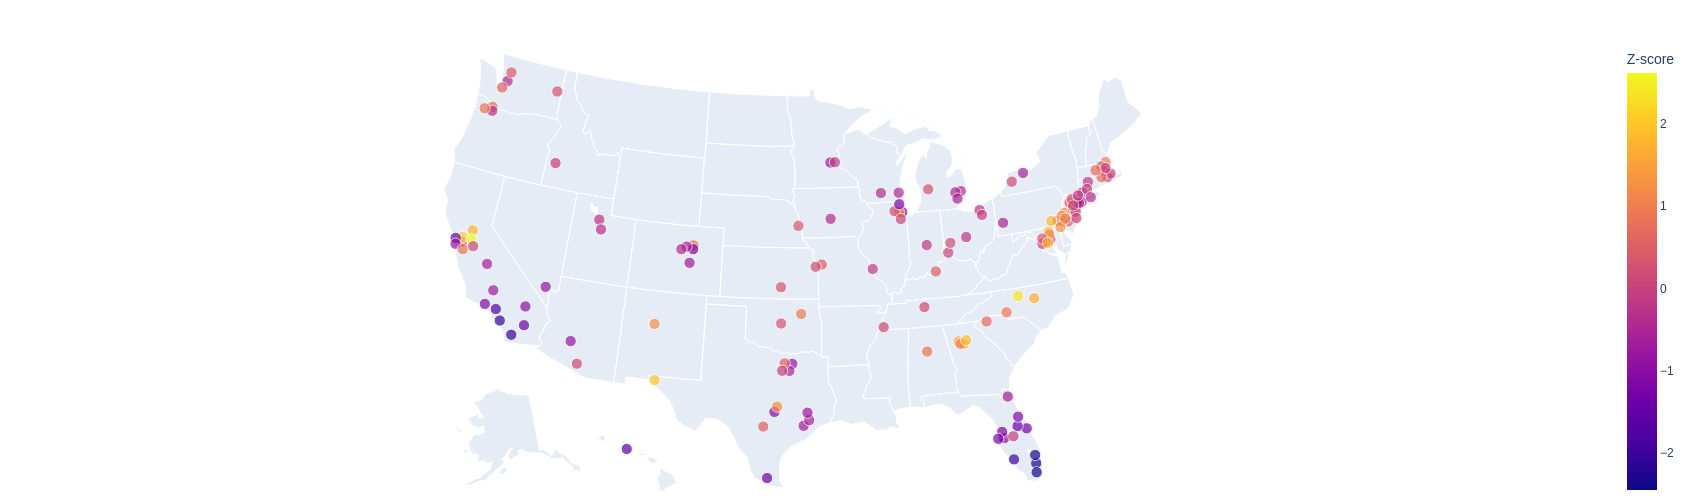

In [44]:
## https://stackoverflow.com/questions/65738987/is-it-possible-to-create-a-subplot-with-plotly-express
# https://stackoverflow.com/questions/65696083/is-there-a-way-to-use-plotly-express-to-show-multiple-subplots
# https://plotly.com/python/plotly-express/
# https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html

year_counties_z_2 = year_counties_z.copy()
year_counties_z_2['Size'] = 1
year_counties_z_2.rename(columns={"year_int_z": "Z-score"}, inplace=True)

fig = px.scatter_geo(year_counties_z_2,
                      lat = 'Lat',
                      lon = 'Long_',
                      hover_name = 'Combined_Key',
                      hover_data = ['Z-score'],
                      size = 'Size',
                      size_max=8,
                      scope = 'usa',
                      color = 'Z-score',
                      width = 850,
                      height = 500)
fig.update_layout(title_x=0.5)
fig.update_layout(title={'font': {'size': 24}})
fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

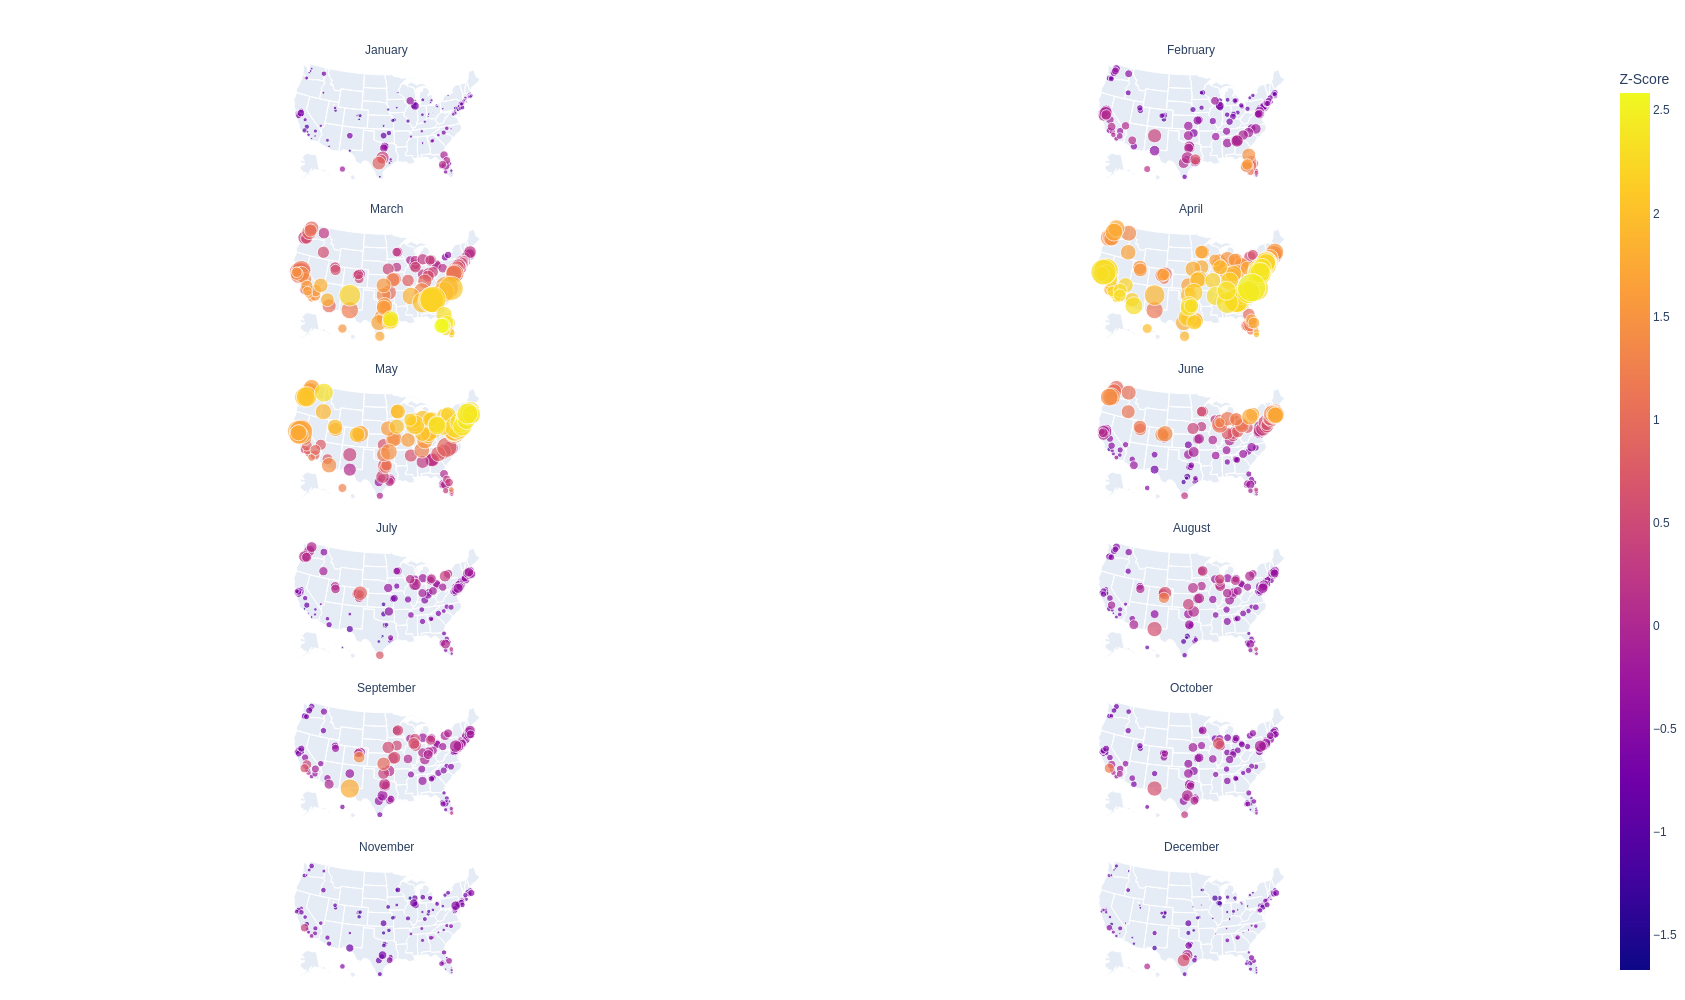

In [45]:
# https://stackoverflow.com/questions/65738987/is-it-possible-to-create-a-subplot-with-plotly-express
# https://stackoverflow.com/questions/65696083/is-there-a-way-to-use-plotly-express-to-show-multiple-subplots
# https://plotly.com/python/plotly-express/
# https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html

fig = px.scatter_geo(melt,
                      lat = 'Lat',
                      lon = 'Long_',
                      facet_col='facet',
                      facet_col_wrap = 2,
                      facet_col_spacing = 0.0,
                      facet_row_spacing = 0.04,
                      hover_name = 'Combined_Key',
                      hover_data = ['Intensity','Z-Score'],
                      size = 'Intensity',
                      scope = 'usa',
                      color = 'Z-Score',
                      width = 850,
                      height = 1000)


fig.for_each_annotation(lambda a: a.update(text=a.text.replace("facet=", "")))
fig.update_layout(title_x=0.5)
fig.update_layout(title={'font': {'size': 24}})
fig.update_layout(
    margin=dict(l=0, r=20, t=60, b=20)
)

fig.show()


## Animation

In [39]:
# dataset for animation
all_tweets = all_tweets_merged
all_tweets = all_tweets[all_tweets['date'] >= '2016-01-01']
all_tweets = all_tweets.rename(columns={'fips': 'FIPS'})
all_tweets_geolocated = pd.merge(all_tweets, fips_counties, on=['FIPS'], how='left')
all_tweets_geolocated = all_tweets_geolocated.rename(columns={'14dra_percent': 'Raw_Intensity','date': 'Date'})
tweets_geo_set = all_tweets_geolocated[['Combined_Key','Lat','Long_','Date','Raw_Intensity']]

In [40]:
daily_geo = pd.DataFrame()

for i in  tweets_geo_set['Combined_Key'].unique().tolist():
    county = tweets_geo_set.loc[(tweets_geo_set['Combined_Key'] == i)]
    gmin = county['Raw_Intensity'].min()
    county['Intensity'] = county['Raw_Intensity']-gmin
    county['Z-score'] = zscore(county['Intensity'], axis=0)
    county = county[['Combined_Key','Lat','Long_','Date','Intensity','Z-score']]
    daily_geo = pd.concat((daily_geo, county), ignore_index = True, axis=0)

,Combined_Key,Lat,Long_,Date,Intensity,Z-score
0,"Ada, Idaho, US",43.452658,-116.241552,2016-01-01,0.001409,-0.945480
1,"Ada, Idaho, US",43.452658,-116.241552,2016-01-02,0.001408,-0.945607
2,"Ada, Idaho, US",43.452658,-116.241552,2016-01-03,0.001403,-0.946070
3,"Ada, Idaho, US",43.452658,-116.241552,2016-01-04,0.001409,-0.945516
4,"Ada, Idaho, US",43.452658,-116.241552,2016-01-05,0.001410,-0.945414
...,...,...,...,...,...,...
367915,"Worcester, Massachusetts, US",42.350270,-71.904934,2022-12-27,0.004038,-0.768782
367916,"Worcester, Massachusetts, US",42.350270,-71.904934,2022-12-28,0.004069,-0.766526
367917,"Worcester, Massachusetts, US",42.350270,-71.904934,2022-12-29,0.004090,-0.765051
367918,"Worcester, Massachusetts, US",42.350270,-71.904934,2022-12-30,0.004092,-0.764911


In [41]:
#Writing a csv file for other calculations

pd.merge(daily_geo[['Combined_Key','Date','Intensity']], all_tweets_geolocated[['FIPS','Combined_Key']].drop_duplicates(), on='Combined_Key', how='inner').to_csv('./final_intensity_by_county.csv', sep='\t')

# Interactive map, all days, 2016-2022

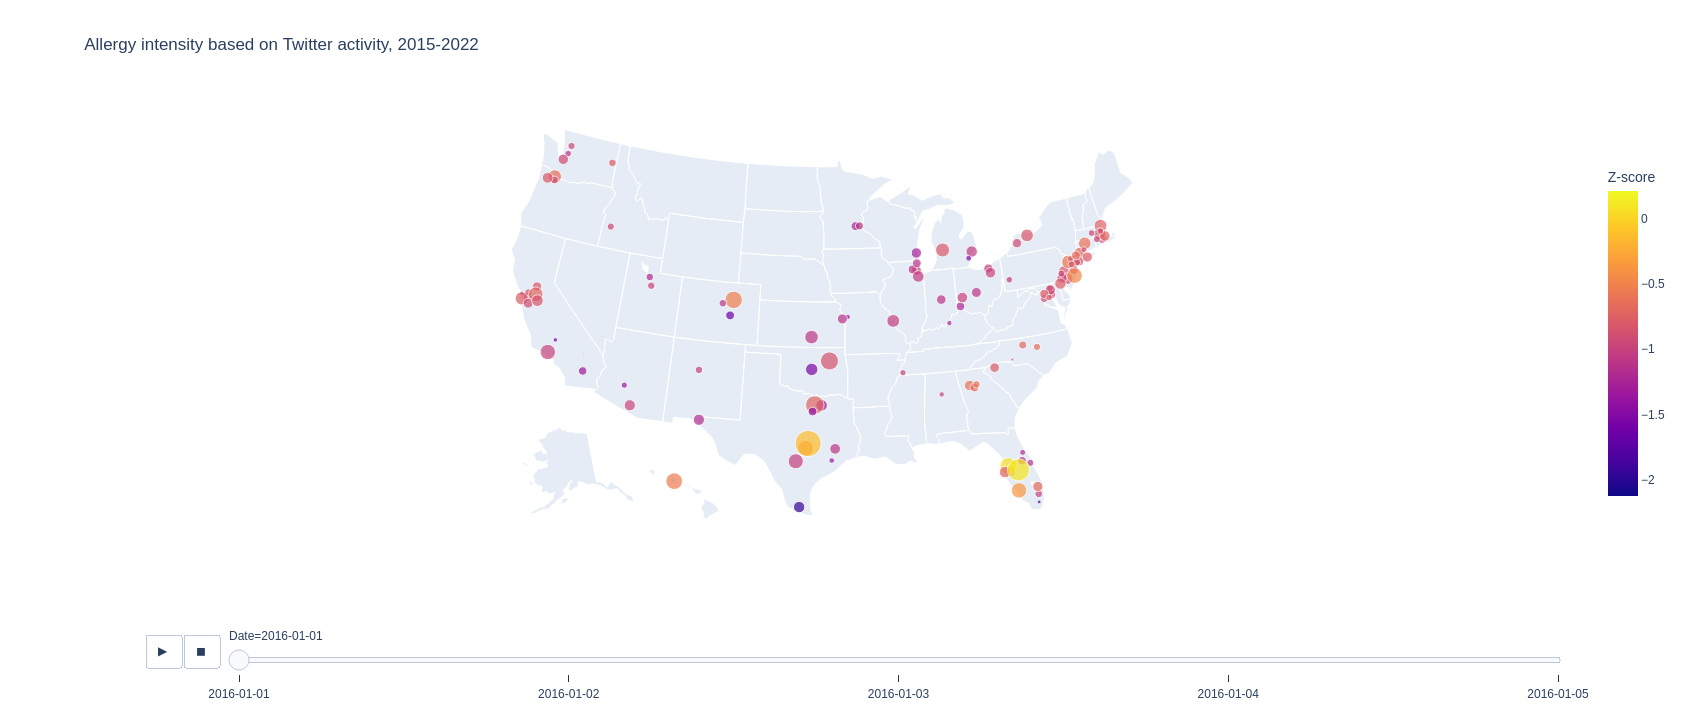

In [42]:
import plotly.express as px

daily_geo['Date'] = daily_geo['Date'].astype(str)
daily_geo['Intensity'] = daily_geo['Intensity']*500
daily_geo = daily_geo[daily_geo['Date'] < '2016-01-06']
color_max = max(daily_geo['Z-score'])
color_min = min(daily_geo['Z-score'])
fig = px.scatter_geo(daily_geo,
               animation_frame='Date',
               animation_group='Combined_Key',
               lat = 'Lat',
               lon = 'Long_',
               hover_name = 'Combined_Key',
               hover_data = ['Intensity','Z-score'],
               size = 'Intensity',
               scope = 'usa',
               color = 'Z-score',
               range_color=(color_min,color_max),
               title = 'Allergy intensity based on Twitter activity, 2015-2022',
               width = 1280,
               height = 720)

fig.update_coloraxes(colorbar_lenmode='fraction', colorbar_len=0.75)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig

# Code to make movie included in sup materials

This section has been blocked out as it is time consuming and somewhat computationally intensive; however, it works shoyuld you wish to run it

In [96]:
'''
daily_geo_gif = daily_geo
daily_geo_gif['Date'] = daily_geo['Date'].astype(str)
'''

In [1100]:
'''
fig = px.scatter_geo(daily_geo_gif,
               animation_frame='Date',
               animation_group='Combined_Key',
               lat = 'Lat',
               lon = 'Long_',
               #facet_col='Date',
               #facet_col_wrap = 2,
               #facet_col_spacing = 0.0,
               #facet_row_spacing = 0.00549,
               hover_name = 'Combined_Key',
               hover_data = ['Intensity','Z-score'],
                      #labels={
                      #"facet=January": "January"
                      #        },
               size = 'Intensity',
               scope = 'usa',
                      #title="Relative Intensity of Allergies & Relative Seasonal Severity",
                      #title = 'Relative Intensity of Allergies & Relative Seasonal Severity',
               color = 'Z-score',
               range_color=(color_min,color_max),
               title = 'Allergy intensity based on Twitter activity, 2015-2022',
               width = 1280,
               height = 720)
#fig.update_coloraxes(colorbar_lenmode='fraction', colorbar_len=0.65)

# smaple plotly animated figure
#fig = px.bar(geo_df, x="x", y="y", animation_frame="step")

# generate images for each step in animation
frames = []
for s, fr in enumerate(fig.frames):
    # set main traces to appropriate traces within plotly frame
    fig.update(data=fr.data)
    # move slider to correct place
    fig.layout.sliders[0].update(active=s)
    # generate image of current state
    frames.append(PIL.Image.open(io.BytesIO(fig.to_image(format="png"))))
    
# create animated GIF
frames[0].save(
        "seven_year_allergy_timelapse.gif",
        save_all=True,
        append_images=frames[1:],
        optimize=True,
        duration=100,
        loop=0,
    )
'''